In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mglearn
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1) Data manipulation and vizualisation

In [2]:
!ls data

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [3]:
item_cat_df = pd.read_csv("data/item_categories.csv")
items_df = pd.read_csv("data/items.csv")
shops_df = pd.read_csv("data/shops.csv")
sales_df = pd.read_csv("data/sales_train.csv", parse_dates=["date"], dayfirst=True)

In [4]:
sales_df.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


In [5]:
 sales_df.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [6]:
items_df.tail(3)

,item_name,item_id,item_category_id
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62
22169,Яйцо дракона (Игра престолов),22169,69


In [7]:
shops_df.tail(3)

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


In [8]:
item_cat_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
sales_df.shape, items_df.shape, shops_df.shape, item_cat_df.shape

((2935849, 6), (22170, 3), (60, 2), (84, 2))

## Null or nan values 

In [10]:
sales_df.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [11]:
items_df.isna().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [12]:
shops_df.isna().sum()

shop_name    0
shop_id      0
dtype: int64

In [13]:
item_cat_df.isna().sum()

item_category_name    0
item_category_id      0
dtype: int64

## Outliers data 

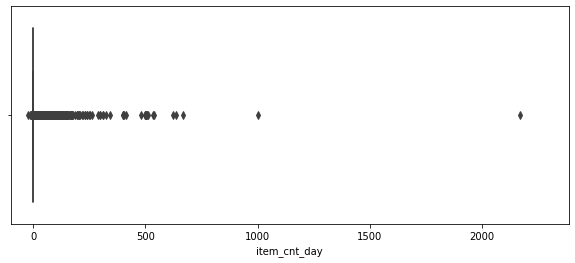

In [14]:
###  Item_cnt_day values
plt.figure(figsize=(10,4))
plt.xlim(-100, sales_df.item_cnt_day.max()*1.1)
sns.boxplot(x=sales_df.item_cnt_day)
plt.show()

In [15]:
sales_df.item_cnt_day.sort_values(ascending=False)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
            ...  
940092       -6.0
59156        -6.0
2048519      -9.0
1835454     -16.0
1057907     -22.0
Name: item_cnt_day, Length: 2935849, dtype: float64

2k sell in one day for one product strange.
Maybe should not consider this point

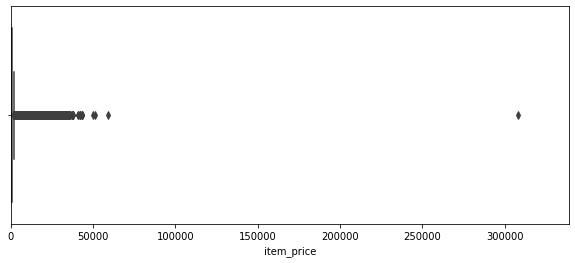

In [16]:
### Prices values
plt.figure(figsize=(10,4))
plt.xlim(sales_df.item_price.min(), sales_df.item_price.max()*1.1)
sns.boxplot(x=sales_df.item_price)
plt.show()

In [17]:
sales_df["item_price"].sort_values(ascending=False)

1163158    307980.0000
885138      59200.0000
1488135     50999.0000
2327159     49782.0000
2910156     42990.0000
              ...     
673155          0.0900
611400          0.0875
579766          0.0700
608763          0.0700
484683         -1.0000
Name: item_price, Length: 2935849, dtype: float64

One item is really more expensive than other (307K and the 2nd more expensive is only 60 K)
one item has also a price < 0. Not possible

In [18]:
# Ok then i remove data where PRICE > 60000 and where ITEM_CNT_DAY > 1000
sales_df = sales_df[(sales_df["item_price"]<60000) & (sales_df["item_cnt_day"]<1000)]

In [19]:
# price negatif ??
sales_df[sales_df['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [20]:
sales_df[(sales_df['shop_id']==32) & (sales_df["item_id"]==2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,2013-01-29,0,32,2973,2499.0,1.0
67428,2013-01-25,0,32,2973,2499.0,1.0
67429,2013-01-22,0,32,2973,2499.0,1.0
67430,2013-01-21,0,32,2973,2499.0,1.0
67431,2013-01-18,0,32,2973,2499.0,1.0
67432,2013-01-17,0,32,2973,2499.0,1.0
67433,2013-01-15,0,32,2973,2499.0,3.0
187844,2013-02-05,1,32,2973,2499.0,1.0
187845,2013-02-14,1,32,2973,2499.0,1.0
484682,2013-05-23,4,32,2973,1249.0,1.0


In [21]:
# Negative price is an error I replace its value by mean for same item_id/shop_id
sales_df.loc[sales_df["item_price"]<0, "item_price"] = sales_df[(sales_df['shop_id']==32) & (sales_df["item_id"]==2973) & (sales_df['item_price']>0)].item_price.mean()

## Features type: Category

####  Shops

In [22]:
shops_df['shop_name'].head(3)

0    !Якутск Орджоникидзе, 56 фран
1    !Якутск ТЦ "Центральный" фран
2                 Адыгея ТЦ "Мега"
Name: shop_name, dtype: object

we can notice that first part of the the name is a city in Russia so we can extract this info and create a new column representing city of the shop

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df.loc[shops_df.city == '!Якутск', 'city'] = 'Якутск'
shops_df['city_code'] = LabelEncoder().fit_transform(shops_df['city'])

In [25]:
shops_df = shops_df[["shop_id", "city_code"]]
shops_df.head(3)

,shop_id,city_code
0,0,29
1,1,29
2,2,0


In [26]:
shops_df.dtypes

shop_id      int64
city_code    int64
dtype: object

#### Item category

In [27]:
item_cat_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [28]:
item_cat_df['split'] = item_cat_df['item_category_name'].str.split('-')
item_cat_df['type'] = item_cat_df['split'].map(lambda x: x[0].strip())
item_cat_df['type_code'] = LabelEncoder().fit_transform(item_cat_df['type'])
item_cat_df['subtype'] = item_cat_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cat_df['subtype_code'] = LabelEncoder().fit_transform(item_cat_df['subtype'])

In [29]:
item_cat_df = item_cat_df[['item_category_id','type_code', 'subtype_code']]

In [30]:
item_cat_df.head(3)

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10


In [31]:
item_cat_df.dtypes

item_category_id    int64
type_code           int64
subtype_code        int64
dtype: object

####  Dates

In [32]:
sales_df["year_date"]= sales_df["date"].apply(lambda x: x.year)

In [33]:
sales_df["month_date"] = sales_df["date"].apply(lambda x: x.month)

# Targeted feature 

In [34]:
#Before merging dataframe I'm gonna aggregate sales_df per month to be as in prediction conditions

In [35]:
sales_df.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_date,month_date
0,2013-01-02,0,59,22154,999.0,1.0,2013,1
1,2013-01-03,0,25,2552,899.0,1.0,2013,1
2,2013-01-05,0,25,2552,899.0,-1.0,2013,1


In [36]:
month_sales_df = sales_df.groupby(by=["date_block_num", "shop_id", 'item_id','year_date', 'month_date']).agg({"item_price":"mean", "item_cnt_day":"sum"}).reset_index()
month_sales_df.rename(columns={"item_cnt_day":"item_cnt_month"}, inplace=True)

In [37]:
month_sales_df.head(3)

,date_block_num,shop_id,item_id,year_date,month_date,item_price,item_cnt_month
0,0,0,32,2013,1,221.0,6.0
1,0,0,33,2013,1,347.0,3.0
2,0,0,35,2013,1,247.0,1.0


In [38]:
# New used DF is month_sales_df

# Merging our dataframes

In [39]:
month_sales_df = pd.merge(month_sales_df, shops_df, on='shop_id', how="left")

In [40]:
month_sales_df = pd.merge(month_sales_df, items_df[["item_id", "item_category_id"]], on='item_id', how="left")

In [41]:
month_sales_df = pd.merge(month_sales_df, item_cat_df, on='item_category_id', how="left")

In [42]:
month_sales_df.head()

,date_block_num,shop_id,item_id,year_date,month_date,item_price,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,0,32,2013,1,221.0,6.0,29,40,11,4
1,0,0,33,2013,1,347.0,3.0,29,37,11,1
2,0,0,35,2013,1,247.0,1.0,29,40,11,4
3,0,0,43,2013,1,221.0,1.0,29,40,11,4
4,0,0,51,2013,1,128.5,2.0,29,57,13,8


# 2) Modeling 

## Dealing with categorical features

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
X_train, X_test , y_train, y_test = train_test_split(month_sales_df.drop("item_cnt_month", axis=1), month_sales_df["item_cnt_month"].values, random_state=0, shuffle=False)

In [48]:
categorical_feature = ["shop_id", "item_id", 'month_date', "city_code", "type_code", "subtype_code"]
cat_mask = []
for col in X_train.columns:
    if col in categorical_feature:
        cat_mask.append(True)  
    else:
        cat_mask.append(False)

In [49]:
X_train.head()

,date_block_num,shop_id,item_id,year_date,month_date,item_price,city_code,item_category_id,type_code,subtype_code
0,0,0,32,2013,1,221.0,29,40,11,4
1,0,0,33,2013,1,347.0,29,37,11,1
2,0,0,35,2013,1,247.0,29,40,11,4
3,0,0,43,2013,1,221.0,29,40,11,4
4,0,0,51,2013,1,128.5,29,57,13,8


In [50]:
cat_encod = OneHotEncoder(categorical_features=cat_mask).fit(X_train)

In [51]:
X_train_encoded = cat_encod.transform(X_train)

In [52]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15, n_jobs=-1)

/home/antoine/Documents/Dev/ML/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
rf.fit(X_train_encoded, y_train)

In [179]:
rf.score(X_train_encoded, y_train)

0.7685075123105055

In [180]:
X_test_encoded = cat_encod.transform(X_test)

In [181]:
rf.score(X_test_encoded, y_test)

0.27782252824253395

In [ ]:
Big difference between training and test seems to s

In [182]:
from sklearn.metrics import mean_squared_error 
preds = rf.predict(X_train_encoded)
rmse = np.sqrt(mean_squared_error(preds,y_train))

In [183]:
rmse

3.850056751072454

##  Other tests

In [50]:
item_id_set = set(month_sales_df.item_id.values)
shop_id_set = set(month_sales_df.shop_id.values)
len(item_id_set), len(shop_id_set)

(21806, 60)

###  Linear Regression

In [53]:
from sklearn.linear_model import LinearRegression

In [185]:
X_train.shape, y_train.shape

((1206843, 10), (1206843,))

In [55]:
lr = LinearRegression().fit(X_train, y_train)

In [56]:
lr.score(X_train, y_train)

0.01026485813839595

In [187]:
# With OneHotEncoding

In [184]:
lr_Onehot2 = LinearRegression().fit(X_train_encoded,y_train)

In [186]:
lr_Onehot2.score(X_train_encoded, y_train)

0.3770848948317731

In [87]:
preds = lr_Onehot2.predict(X_train2)

In [88]:
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,y_train))

In [89]:
rmse

6.315554720814424

### Grid Search for RandomForest params

In [98]:
grid_p = {"n_estimators": [10, 100, 1000], "max_depth":[5, 10, 20]}

In [99]:
gs = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_grid=grid_p)

In [100]:
gs.fit(X_train2, y_train)

KeyboardInterrupt: 

### Xgboost but not really working

In [91]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb


In [119]:
regressor = xgb.XGBRegressor(n_estimators = 500,
                                 learning_rate = 0.01,
                                 max_depth = 10,
                                 subsample = 0.5,
                                 colsample_bytree = 0.5)

In [120]:
regressor_ = regressor.fit(X_train2, 
                               y_train, 
                               eval_metric = 'rmse', 
                               #eval_set = [(new_train[new_train.date_block_num < 33].drop(['item_cnt_month'], axis=1).values, 
                                #            new_train[new_train.date_block_num < 33]['item_cnt_month'].values), 
                                 #          (new_train[new_train.date_block_num == 33].drop(['item_cnt_month'], axis=1).values, 
                                  #          new_train[new_train.date_block_num == 33]['item_cnt_month'].values)
                                   #       ], 
                               verbose=True,
#                               early_stopping_rounds = 50,
                              )

[15:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [121]:
regressor_.score(X_train2, y_train)

0.7478117352284552